In [1]:
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

import matplotlib.pyplot as plt

import sys
sys.path.append('../..')

from hiv_patient import HIVPatient

In [2]:


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    def __len__(self):
        return len(self.buffer)

In [3]:
with open('replay_buffer_extratree_osty', 'rb') as f:
    data = pickle.load(f)

actions_set = np.array([([0., 0.]), ([0. , 0.3]), ([0.7, 0. ]), ([0.7, 0.3])])

replay_buffer = ReplayBuffer(60_000)

for i in range(0, data.shape[0]):

    action = data[i, 6:8]

    # map action to index in actions_set=array([[0. , 0. ], [0. , 0.3], [0.7, 0. ], [0.7, 0.3]])
    action_index = np.where((actions_set == action).all(axis=1))[0][0]

    state = np.log10(data[i, :6])
    next_state = np.log10(data[i, 9:])
    # reward = np.log10(data[i, 8])
    reward = data[i, 8] / (123 * 1e6)

    # replay_buffer.push(data[i, :6], data[i, 6:8], data[i, 8], data[i, 9:], False)
    done = False
    if i> 1 and i% 200 == 0:
        done = True
    replay_buffer.push(state, action_index, reward, next_state, done)

In [64]:
class TestDQN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.fc1 = nn.Linear(6, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 512)
        self.fc4 = nn.Linear(512, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 4)

        self.loss = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)

    def forward(self, x):
        x = self.fc1(x)
        
        #  add residual connection betweedn fc1 and fc5
        # out = x

        x = F.relu(x)

        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        # x += out

        x = self.fc6(x)

        return x
    

In [5]:
# make a dataloader calling sample of the replay buffer, getting a pair of state 

In [63]:
epochs = 10_000

device = torch.device("mps")
dqn = TestDQN().to(device)
dqn_target = TestDQN().to(device)

loss_list = []

for epoch in range(epochs):
    state, action, reward, next_state, done = replay_buffer.sample(600)

    # convert to tensors to device
    state = torch.tensor(state, dtype=torch.float32).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)
    reward = torch.tensor(reward, dtype=torch.float32).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
    done = torch.tensor(done, dtype=torch.float32).to(device)


    QYmax = dqn_target(next_state).max(1)[0].detach()
    update = torch.addcmul(reward, 0.98, 1 - done, QYmax)

    QY = dqn(state).gather(1, action.unsqueeze(1)).squeeze(1)
    
    loss = dqn.loss(QY, update)
    dqn.optimizer.zero_grad()
    loss.backward()
    dqn.optimizer.step()

    loss_list.append(loss.item())

    update_delay = 400
    if epoch > 1 and epoch % 5_000 == 0:
        update_delay *= 1.5

    if epoch % update_delay == 0:
        print("*", end="")
        dqn_target.load_state_dict(dqn.state_dict())

        dqn = TestDQN().to(device)

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [MPSFloatType [600, 64]], which is output 0 of ReluBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [65]:
epochs = 10_000

device = torch.device("mps")
dqn = TestDQN().to(device)
dqn_target = TestDQN().to(device)

loss_list = []

for epoch in range(epochs):
    state, action, reward, next_state, done = replay_buffer.sample(600)

    # convert to tensors to device
    state = torch.tensor(state, dtype=torch.float32).to(device)
    action = torch.tensor(action, dtype=torch.int64).to(device)
    reward = torch.tensor(reward, dtype=torch.float32).to(device)
    next_state = torch.tensor(next_state, dtype=torch.float32).to(device)
    done = torch.tensor(done, dtype=torch.float32).to(device)


    QYmax = dqn_target(next_state).max(1)[0].detach()
    update = torch.addcmul(reward, 0.98, 1 - done, QYmax)

    QY = dqn(state).gather(1, action.unsqueeze(1)).squeeze(1)
    
    loss = dqn.loss(QY, update)
    dqn.optimizer.zero_grad()
    loss.backward()
    dqn.optimizer.step()

    loss_list.append(loss.item())

    update_delay = 400
    if epoch > 1 and epoch % 5_000 == 0:
        update_delay *= 1.5

    if epoch % update_delay == 0:
        print("*", end="")
        dqn_target.load_state_dict(dqn.state_dict())

        dqn = TestDQN().to(device)

*************************

In [46]:
patient = HIVPatient(logscale=False, clipping=False)

states = []
state = patient.reset(mode="unhealthy")

total_reward= 0

actions=[]

for i in range(200):
    # q_values = dqn_target(torch.tensor(state, dtype=torch.float32).to(device))
    state = np.log10(state)
    q_values = dqn_target(torch.tensor(state, dtype=torch.float32).to(device))

    action = torch.argmax(q_values).detach().cpu().numpy()
    actions.append(action)

    # print(action)

    state, reward, *_ = patient.step(action)
    states.append(state)

    total_reward += reward

print(total_reward * 1e-6)
print("pro")

states_null = []
state = patient.reset(mode="unhealthy")
total_reward_null = 0

# action = patient.action_set[0]
action = 3
for i in range(200):
    # action = greedy_action(DQN, state)
    state, reward, *_ = patient.step(action)
    states_null.append(state)
    total_reward_null += reward

print(total_reward_null * 1e-6)

16.952952945061526
pro
6.677047843907171


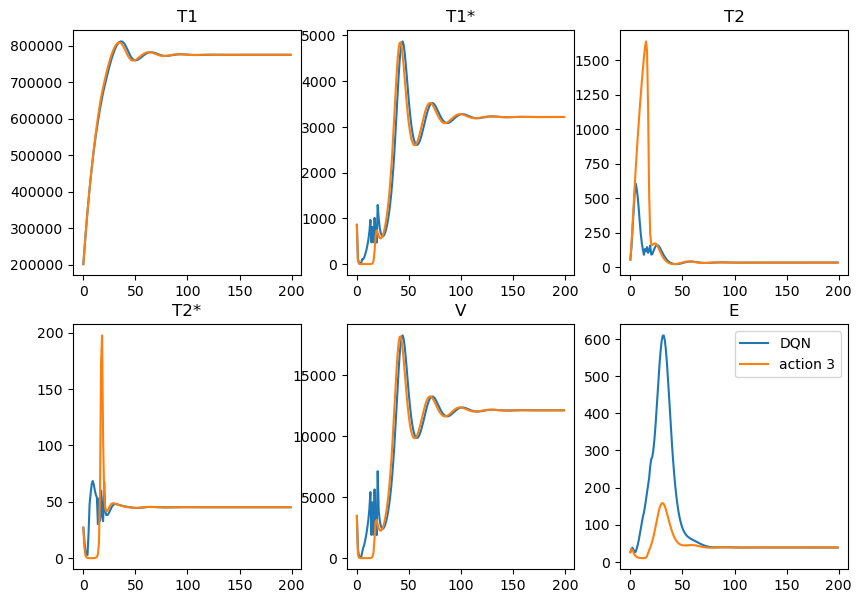

In [47]:
fig, axs = plt.subplots(2, 3, figsize=(10, 7))
npst = np.array(states)
axs[0,0].plot(npst[:,0])
axs[0,0].set_title("T1")
axs[0,1].plot(npst[:,1])
axs[0,1].set_title("T1*")
axs[0,2].plot(npst[:,2])
axs[0,2].set_title("T2")
axs[1,0].plot(npst[:,3])
axs[1,0].set_title("T2*")
axs[1,1].plot(npst[:,4])
axs[1,1].set_title("V")
axs[1,2].plot(npst[:,5])
axs[1,2].set_title("E")

npst = np.array(states_null)
axs[0,0].plot(npst[:,0])
axs[0,1].plot(npst[:,1])
axs[0,2].plot(npst[:,2])
axs[1,0].plot(npst[:,3])
axs[1,1].plot(npst[:,4])
axs[1,2].plot(npst[:,5])

plt.legend(["DQN", "action 3"])

Text(0.5, 1.0, 'Loss')

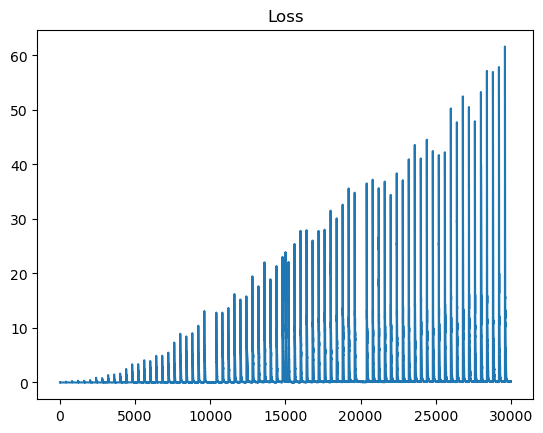

In [48]:
plt.plot(loss_list)
plt.title("Loss")

Text(0.5, 1.0, 'Actions taken by DQN')

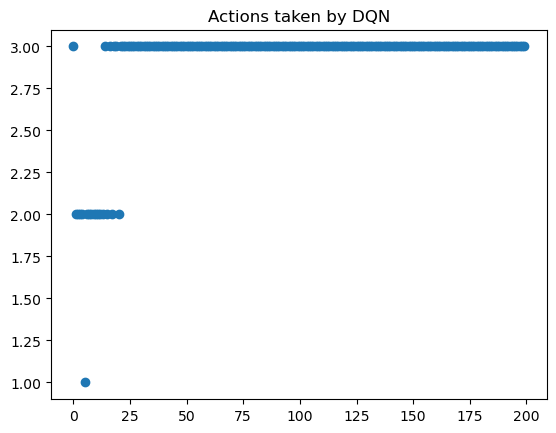

In [49]:
plt.scatter(range(len(actions)), actions)
plt.title("Actions taken by DQN")

In [50]:
pro = replay_buffer.sample(60000)

In [51]:
# count unique values contained in the dataset
unique, counts = np.unique(pro[1], return_counts=True)

In [52]:
counts

array([ 9477, 12110, 15616, 22797])